In [2]:
# Setup: Add project root to path
import sys
from pathlib import Path

# Navigate up from notebooks/testing to project root
project_root = Path.cwd().parent.parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

print(f"Project root: {project_root}")
print(f"Current directory: {Path.cwd()}")

Project root: /Users/Sakarias/QuantTrading
Current directory: /Users/Sakarias/QuantTrading/notebooks/testing


In [3]:
# Import required modules
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Core modules
from core.multi_asset_loader import load_assets
from core.multi_asset_signal import SingleAssetWrapper
from signals.momentum import MomentumSignalV2
from core.portfolio_manager import run_multi_asset_backtest, PortfolioConfig
from core.risk_manager import RiskManager, RiskConfig
from core.paper_trading_engine import PaperTradingEngine

# Dashboard and reporting modules
from core.risk_dashboard import RiskDashboard
from core.reporter import Reporter

print("✅ All modules imported successfully")

✅ All modules imported successfully


## Configuration

In [4]:
# Trading configuration
TICKERS = ['ES', 'GC', 'NQ']  # S&P 500 E-mini, Gold, Nasdaq E-mini
BACKTEST_START = '2010-01-01'
BACKTEST_END = '2024-12-31'
LIVE_START = '2025-01-01'
INITIAL_CAPITAL = 100000

# State persistence
STATE_FILE = project_root / 'data' / 'paper_trading_state.pkl'

print(f"Configuration:")
print(f"  Assets: {TICKERS}")
print(f"  Backtest Period: {BACKTEST_START} to {BACKTEST_END}")
print(f"  Live Trading: {LIVE_START} onward")
print(f"  Initial Capital: ${INITIAL_CAPITAL:,.0f}")
print(f"  State File: {STATE_FILE}")

Configuration:
  Assets: ['ES', 'GC', 'NQ']
  Backtest Period: 2010-01-01 to 2024-12-31
  Live Trading: 2025-01-01 onward
  Initial Capital: $100,000
  State File: /Users/Sakarias/QuantTrading/data/paper_trading_state.pkl


## Phase 1: Run Reference Backtest

First, establish baseline performance on historical data.

In [5]:
# Load historical data
print("="*60)
print("LOADING HISTORICAL DATA")
print("="*60)

prices_backtest = load_assets(
    tickers=TICKERS,
    start_date=BACKTEST_START,
    end_date=BACKTEST_END
)

print(f"\nData Summary:")
for ticker, df in prices_backtest.items():
    print(f"  {ticker}: {len(df)} bars, {df.index[0].date()} to {df.index[-1].date()}")

LOADING HISTORICAL DATA

Loading 3 assets: ['ES', 'GC', 'NQ']
  📡 CSV data is 330 days old, fetching recent data from yfinance...
  ✓ Added 228 days from yfinance (now through 2025-11-26)
✓ ES: 6362 rows, 2000-09-18 to 2025-11-26
  📡 CSV data is 330 days old, fetching recent data from yfinance...
  ✓ Added 228 days from yfinance (now through 2025-11-26)
✓ GC: 6334 rows, 2000-08-30 to 2025-11-26
  📡 CSV data is 330 days old, fetching recent data from yfinance...
  ✓ Added 228 days from yfinance (now through 2025-11-26)
✓ NQ: 6362 rows, 2000-09-18 to 2025-11-26

Common date range: 2000-09-18 to 2025-11-26
Filtered date range: 2010-01-01 to 2024-12-31
  ✓ Added 228 days from yfinance (now through 2025-11-26)
✓ ES: 6362 rows, 2000-09-18 to 2025-11-26
  📡 CSV data is 330 days old, fetching recent data from yfinance...
  ✓ Added 228 days from yfinance (now through 2025-11-26)
✓ GC: 6334 rows, 2000-08-30 to 2025-11-26
  📡 CSV data is 330 days old, fetching recent data from yfinance...
  ✓ Add

In [6]:
# Generate signals
print("\nGenerating trading signals...")

signal_gen = MomentumSignalV2(lookback=120, sma_filter=200)
multi_signal = SingleAssetWrapper(signal_gen)
signals_backtest = multi_signal.generate(prices_backtest)

print(f"\nSignal Statistics:")
for ticker in TICKERS:
    sig = signals_backtest[ticker]['Signal']
    n_long = (sig == 1).sum()
    print(f"  {ticker}: {n_long}/{len(sig)} days long ({n_long/len(sig)*100:.1f}%)")


Generating trading signals...

Signal Statistics:
  ES: 3553/3773 days long (94.2%)
  GC: 3553/3773 days long (94.2%)
  NQ: 3553/3773 days long (94.2%)


In [7]:
# Run backtest
print("\n" + "="*60)
print("RUNNING BACKTEST")
print("="*60)

# Configure risk management
risk_config = RiskConfig(
    position_sizing_method='vol_adjusted',
    max_position_size=0.35,
    max_leverage=1.0,
    max_drawdown_stop=-0.2,
    volatility_target=0.24,
    correlation_threshold=0.70
)
risk_mgr_backtest = RiskManager(risk_config)

config_backtest = PortfolioConfig(
    initial_capital=INITIAL_CAPITAL,
    rebalance_threshold=0.1,
    transaction_cost_bps=3.0,
    risk_manager=risk_mgr_backtest,
    rejection_policy='skip'
)

result_backtest, equity_backtest, trades_backtest = run_multi_asset_backtest(
    signals_dict=signals_backtest,
    prices_dict=prices_backtest,
    config=config_backtest,
    return_pm=False
)

# Display metrics
metrics_backtest = result_backtest.calculate_metrics()

print(f"\n📊 Backtest Results:")
print(f"  Total Return: {metrics_backtest['Total Return']:.2%}")
print(f"  CAGR: {metrics_backtest['CAGR']:.2%}")
print(f"  Sharpe Ratio: {metrics_backtest['Sharpe Ratio']:.3f}")
print(f"  Max Drawdown: {metrics_backtest['Max Drawdown']:.2%}")
print(f"  Volatility: {metrics_backtest['Annual Volatility']:.2%}")
print(f"  Total Trades: {len(trades_backtest)}")
print(f"  Rebalances: {metrics_backtest['Rebalances']}")


RUNNING BACKTEST

📊 Backtest Results:
  Total Return: 122.05%
  CAGR: 8.15%
  Sharpe Ratio: 0.726
  Max Drawdown: -21.02%
  Volatility: 11.76%
  Total Trades: 15
  Rebalances: 12

📊 Backtest Results:
  Total Return: 122.05%
  CAGR: 8.15%
  Sharpe Ratio: 0.726
  Max Drawdown: -21.02%
  Volatility: 11.76%
  Total Trades: 15
  Rebalances: 12


## Phase 2: Initialize Paper Trading Engine

Create or load existing paper trading state.

In [8]:
print("\n" + "="*60)
print("PAPER TRADING ENGINE INITIALIZATION")
print("="*60)

# Create config for live trading
risk_mgr_live = RiskManager(risk_config)
config_live = PortfolioConfig(
    initial_capital=INITIAL_CAPITAL,
    rebalance_threshold=0.05,
    transaction_cost_bps=3.0,
    risk_manager=risk_mgr_live,
    rejection_policy='skip'
)

# Track if we just initialized (to skip redundant update)
just_initialized = False

# Check if state file exists
if STATE_FILE.exists():
    print(f"\n📂 Loading existing state from: {STATE_FILE}")
    engine = PaperTradingEngine.load_state(str(STATE_FILE), config_live)
    print("✅ State loaded successfully")
    
    # Show state summary
    summary = engine.export_state_summary()
    print(f"\nState Summary:")
    for key, value in summary.items():
        print(f"  {key}: {value}")
else:
    print(f"\n🆕 No existing state found, initializing fresh...")
    
    # Create new engine with backtest reference
    engine = PaperTradingEngine(
        config=config_live,
        backtest_result=result_backtest,
        backtest_equity=equity_backtest,
        backtest_trades=trades_backtest
    )
    
    # Load live data and initialize
    prices_live = load_assets(
        tickers=TICKERS,
        start_date='2024-01-01',  # Need history for indicators
        end_date='2025-12-31'
    )
    
    signals_live = multi_signal.generate(prices_live)
    
    engine.initialize(
        prices_dict=prices_live,
        signals_dict=signals_live,
        start_date=LIVE_START
    )
    
    # Save initial state
    STATE_FILE.parent.mkdir(exist_ok=True)
    engine.save_state(str(STATE_FILE))
    
    # Set flag so we skip redundant update
    just_initialized = True
    
    print(f"✅ Engine initialized and saved to: {STATE_FILE}")
    print(f"ℹ️  Skip Phase 3 (Daily Update) - engine just initialized with current data")


PAPER TRADING ENGINE INITIALIZATION

📂 Loading existing state from: /Users/Sakarias/QuantTrading/data/paper_trading_state.pkl
✅ State loaded successfully

State Summary:
  last_update: 2025-11-26 00:00:00
  num_positions: 3
  cash: 284.2775369339215
  equity_curve_length: 480
  total_trades: 9
  initial_capital: 100000
  has_backtest_reference: True


## Phase 3: Daily Update

Fetch latest data and update portfolio (run this daily).

In [9]:
# Skip update if we just initialized (already has current data)
if just_initialized:
    print("="*60)
    print("DAILY UPDATE - SKIPPED")
    print("="*60)
    print("\nℹ️  Engine was just initialized with current data.")
    print("   Run this cell tomorrow or when you want to fetch new data.")
    
    # For continuity, set these variables from the initialization
    prices_current = prices_live
    signals_current = signals_live
else:
    print("\n" + "="*60)
    print("DAILY UPDATE")
    print("="*60)
    
    # Load latest data (yfinance will auto-fetch if stale)
    prices_current = load_assets(
        tickers=TICKERS,
        start_date='2024-01-01',  # Need history for indicators
        end_date='2025-12-31'
    )
    
    # Generate signals on latest data
    signals_current = multi_signal.generate(prices_current)
    
    # Update engine
    equity_updated, trades_updated = engine.update(
        prices_dict=prices_current,
        signals_dict=signals_current
    )
    
    # Save updated state
    engine.save_state(str(STATE_FILE))
    
    print(f"\n✅ Update complete:")
    print(f"  Equity curve length: {len(equity_updated)}")
    print(f"  Total trades: {len(trades_updated)}")
    print(f"  State saved: {STATE_FILE}")


DAILY UPDATE

Loading 3 assets: ['ES', 'GC', 'NQ']
  📡 CSV data is 330 days old, fetching recent data from yfinance...
  ✓ Added 228 days from yfinance (now through 2025-11-26)
✓ ES: 6362 rows, 2000-09-18 to 2025-11-26
  📡 CSV data is 330 days old, fetching recent data from yfinance...
  ✓ Added 228 days from yfinance (now through 2025-11-26)
✓ GC: 6334 rows, 2000-08-30 to 2025-11-26
  📡 CSV data is 330 days old, fetching recent data from yfinance...
  ✓ Added 228 days from yfinance (now through 2025-11-26)
✓ NQ: 6362 rows, 2000-09-18 to 2025-11-26

Common date range: 2000-09-18 to 2025-11-26
Filtered date range: 2024-01-01 to 2025-11-26

Total unique dates: 480

ALIGNMENT SUMMARY
ES: 480/480 valid dates (100.0%)
GC: 480/480 valid dates (100.0%)
NQ: 480/480 valid dates (100.0%)
  ✓ Added 228 days from yfinance (now through 2025-11-26)
✓ GC: 6334 rows, 2000-08-30 to 2025-11-26
  📡 CSV data is 330 days old, fetching recent data from yfinance...
  ✓ Added 228 days from yfinance (now thro

## Phase 4: Portfolio Status

View current positions and performance.

In [11]:
print("\n" + "="*60)
print("CURRENT PORTFOLIO STATUS")
print("="*60)

status = engine.get_portfolio_status(prices_current)

if status['status'] == 'not_initialized':
    print(f"\n⚠️  {status['message']}")
else:
    print(f"\nAs of: {status['as_of_date'].date()}")
    print(f"\nPortfolio Value: ${status['total_value']:,.2f}")
    print(f"  Cash: ${status['cash']:,.2f} ({status['cash']/status['total_value']*100:.1f}%)")
    print(f"  Invested: ${status['invested']:,.2f} ({status['invested']/status['total_value']*100:.1f}%)")
    print(f"  Total Return: {status['total_return']:.2%}")
    print(f"  P&L: ${(status['total_value'] - status['initial_capital']):,.2f}")
    
    if status['num_positions'] > 0:
        print(f"\n📍 Open Positions: {status['num_positions']}")
        
        for pos in status['positions']:
            print(f"\n  {pos['ticker']}:")
            print(f"    Shares: {pos['shares']:.0f}")
            print(f"    Current Price: ${pos['current_price']:.2f}")
            print(f"    Position Value: ${pos['position_value']:,.2f}")
            
            if pos['entry_price']:
                print(f"    Entry: ${pos['entry_price']:.2f} on {pos['entry_date'].date()}")
                print(f"    Unrealized P&L: ${pos['unrealized_pnl']:,.2f} ({pos['unrealized_pct']:+.2f}%)")
    else:
        print(f"\n💰 No open positions - 100% cash")
    
    # Show current signals
    print(f"\n📊 Current Signals:")
    for ticker in TICKERS:
        if len(signals_current[ticker]) > 0:
            latest_signal = signals_current[ticker]['Signal'].iloc[-1]
            signal_text = "LONG" if latest_signal == 1 else "FLAT"
            print(f"  {ticker}: {signal_text}")


CURRENT PORTFOLIO STATUS

As of: 2025-11-26

Portfolio Value: $132,729.52
  Cash: $284.28 (0.2%)
  Invested: $132,445.24 (99.8%)
  Total Return: 32.73%
  P&L: $32,729.52

📍 Open Positions: 3

  ES:
    Shares: 6
    Current Price: $6841.50
    Position Value: $43,433.75
    Entry: $5305.75 on 2025-04-16
    Unrealized P&L: $9,749.82 (+28.95%)

  GC:
    Shares: 10
    Current Price: $4203.60
    Position Value: $42,564.11
    Entry: $3326.60 on 2025-04-16
    Unrealized P&L: $8,880.18 (+26.36%)

  NQ:
    Shares: 2
    Current Price: $25351.75
    Position Value: $46,447.38
    Entry: $18385.25 on 2025-04-16
    Unrealized P&L: $12,763.44 (+37.89%)

📊 Current Signals:
  ES: LONG
  GC: LONG
  NQ: LONG


In [12]:
# Check recent trades
print("Recent Trades:")
display(engine.state.trades)

# Check violations
if hasattr(engine.state, 'backtest_result') and engine.state.backtest_result:
    violations = engine.state.backtest_result.violations
    if violations is not None and len(violations) > 0:
        print("\nRecent Violations:")
        display(violations.tail(20))

Recent Trades:


Recent Trades:


,Date,Ticker,Type,Shares,Price,Value,TransactionCost,Signal,PrevSignal,Note,CurrentValue,TargetValue
0,2024-11-14,ES,Entry,5.854556,5978.250000,35000.000000,10.500000,1.0,0.0,Used available cash,NaN,NaN
1,2024-11-14,GC,Entry,13.628222,2568.199951,35000.000000,10.500000,1.0,0.0,Used available cash,NaN,NaN
2,2024-11-14,NQ,Entry,1.412505,21011.750000,29679.210000,8.903763,1.0,0.0,Used available cash,NaN,NaN
3,2025-02-27,ES,Rebalance,-0.023090,5876.250000,-135.682566,0.040705,1.0,NaN,NaN,34402.835278,34267.152712
4,2025-02-27,GC,Rebalance,-1.743111,2883.199951,-5025.737332,1.507721,1.0,NaN,NaN,39292.890043,34267.152712
5,2025-02-27,NQ,Rebalance,0.250484,20605.750000,5161.419898,1.548426,1.0,NaN,NaN,29105.732814,34267.152712
6,2025-04-16,ES,Rebalance,0.517105,5305.750000,2743.631353,0.823089,1.0,NaN,NaN,30940.301298,33683.932651
7,2025-04-16,GC,Rebalance,-1.759478,3326.600098,-5853.080212,1.755924,1.0,NaN,NaN,39537.012864,33683.932651
8,2025-04-16,NQ,Rebalance,0.169127,18385.250000,3109.448859,0.932835,1.0,NaN,NaN,30574.483792,33683.932651



Recent Violations:


,ticker,type,reason,timestamp,date
0,PORTFOLIO,drawdown_stop,Max drawdown -21.02% exceeds stop -20.00%,2025-11-25 21:48:51.264238,NaT
1,PORTFOLIO,STOP,Max drawdown -21.02% exceeds stop -20.00%,2020-03-16 00:00:00.000000,2020-03-16


In [13]:
# Deep diagnostic of portfolio state
print("="*60)
print("PORTFOLIO STATE DIAGNOSTIC")
print("="*60)

# Check equity curve
if len(engine.state.equity_curve) > 0:
    print(f"\nEquity Curve: {len(engine.state.equity_curve)} rows")
    print("\nLast 3 rows:")
    display(engine.state.equity_curve[['Date', 'TotalValue', 'Cash', 'Positions']].tail(10))
else:
    print("\n⚠️ Equity curve is empty!")

# Check trades
print(f"\nTrades: {len(engine.state.trades)} total")
if len(engine.state.trades) > 0:
    print("\nLast 10 trades:")
    display(engine.state.trades.tail(10))

# Check if fresh state was created
print(f"\nState Summary:")
print(f"  Initial Capital: ${engine.state.initial_capital:,.0f}")
print(f"  Last Update: {engine.state.last_update}")
print(f"  Current Cash: ${engine.state.cash:,.2f}")
print(f"  Current Positions: {engine.state.positions}")

# Check if we're using the fixed engine
print(f"\nConfiguration:")
print(f"  Risk Manager Violations: ", end="")
if hasattr(engine.config, 'risk_manager') and hasattr(engine.config.risk_manager, 'violations'):
    viols = engine.config.risk_manager.violations
    print(f"{len(viols) if viols is not None else 0}")
else:
    print("N/A")

PORTFOLIO STATE DIAGNOSTIC

Equity Curve: 480 rows

Last 3 rows:


PORTFOLIO STATE DIAGNOSTIC

Equity Curve: 480 rows

Last 3 rows:


,Date,TotalValue,Cash,Positions
470,2025-11-12,133453.391798,284.277537,"{'ES': {'Shares': 6.348571389728232, 'Price': ..."
471,2025-11-13,131572.156082,284.277537,"{'ES': {'Shares': 6.348571389728232, 'Price': ..."
472,2025-11-14,130535.152873,284.277537,"{'ES': {'Shares': 6.348571389728232, 'Price': ..."
473,2025-11-17,129544.275319,284.277537,"{'ES': {'Shares': 6.348571389728232, 'Price': ..."
474,2025-11-18,128622.735836,284.277537,"{'ES': {'Shares': 6.348571389728232, 'Price': ..."
475,2025-11-19,129157.723427,284.277537,"{'ES': {'Shares': 6.348571389728232, 'Price': ..."
476,2025-11-20,127201.401897,284.277537,"{'ES': {'Shares': 6.348571389728232, 'Price': ..."
477,2025-11-21,128123.100441,284.277537,"{'ES': {'Shares': 6.348571389728232, 'Price': ..."
478,2025-11-24,130095.808610,284.277537,"{'ES': {'Shares': 6.348571389728232, 'Price': ..."
479,2025-11-26,132729.518822,284.277537,"{'ES': {'Shares': 6.348571389728232, 'Price': ..."


PORTFOLIO STATE DIAGNOSTIC

Equity Curve: 480 rows

Last 3 rows:


,Date,TotalValue,Cash,Positions
470,2025-11-12,133453.391798,284.277537,"{'ES': {'Shares': 6.348571389728232, 'Price': ..."
471,2025-11-13,131572.156082,284.277537,"{'ES': {'Shares': 6.348571389728232, 'Price': ..."
472,2025-11-14,130535.152873,284.277537,"{'ES': {'Shares': 6.348571389728232, 'Price': ..."
473,2025-11-17,129544.275319,284.277537,"{'ES': {'Shares': 6.348571389728232, 'Price': ..."
474,2025-11-18,128622.735836,284.277537,"{'ES': {'Shares': 6.348571389728232, 'Price': ..."
475,2025-11-19,129157.723427,284.277537,"{'ES': {'Shares': 6.348571389728232, 'Price': ..."
476,2025-11-20,127201.401897,284.277537,"{'ES': {'Shares': 6.348571389728232, 'Price': ..."
477,2025-11-21,128123.100441,284.277537,"{'ES': {'Shares': 6.348571389728232, 'Price': ..."
478,2025-11-24,130095.808610,284.277537,"{'ES': {'Shares': 6.348571389728232, 'Price': ..."
479,2025-11-26,132729.518822,284.277537,"{'ES': {'Shares': 6.348571389728232, 'Price': ..."



Trades: 9 total

Last 10 trades:


,Date,Ticker,Type,Shares,Price,Value,TransactionCost,Signal,PrevSignal,Note,CurrentValue,TargetValue
0,2024-11-14,ES,Entry,5.854556,5978.250000,35000.000000,10.500000,1.0,0.0,Used available cash,NaN,NaN
1,2024-11-14,GC,Entry,13.628222,2568.199951,35000.000000,10.500000,1.0,0.0,Used available cash,NaN,NaN
2,2024-11-14,NQ,Entry,1.412505,21011.750000,29679.210000,8.903763,1.0,0.0,Used available cash,NaN,NaN
3,2025-02-27,ES,Rebalance,-0.023090,5876.250000,-135.682566,0.040705,1.0,NaN,NaN,34402.835278,34267.152712
4,2025-02-27,GC,Rebalance,-1.743111,2883.199951,-5025.737332,1.507721,1.0,NaN,NaN,39292.890043,34267.152712
5,2025-02-27,NQ,Rebalance,0.250484,20605.750000,5161.419898,1.548426,1.0,NaN,NaN,29105.732814,34267.152712
6,2025-04-16,ES,Rebalance,0.517105,5305.750000,2743.631353,0.823089,1.0,NaN,NaN,30940.301298,33683.932651
7,2025-04-16,GC,Rebalance,-1.759478,3326.600098,-5853.080212,1.755924,1.0,NaN,NaN,39537.012864,33683.932651
8,2025-04-16,NQ,Rebalance,0.169127,18385.250000,3109.448859,0.932835,1.0,NaN,NaN,30574.483792,33683.932651



State Summary:
  Initial Capital: $100,000
  Last Update: 2025-11-26 00:00:00
  Current Cash: $284.28
  Current Positions: {'ES': {'Shares': np.float64(6.348571389728232), 'Price': np.float64(6841.5), 'Value': np.float64(43433.7511628257), 'Weight': np.float64(0.3272350532736333)}, 'GC': {'Shares': np.float64(10.125633277887088), 'Price': np.float64(4203.60009765625), 'Value': np.float64(42564.11303575754), 'Weight': np.float64(0.320683096069359)}, 'NQ': {'Shares': np.float64(1.83211719454729), 'Price': np.float64(25351.75), 'Value': np.float64(46447.37708686426), 'Weight': np.float64(0.3499400698424901)}}

Configuration:
  Risk Manager Violations: N/A


### 🔧 Fix Applied: Case-Sensitive Key Issue

The issue was that positions are stored with uppercase keys (`'Shares'`) but the status method was looking for lowercase (`'shares'`). This made it appear like there were no positions when in fact the portfolio is fully invested (105% exposure).

**Note on Negative Cash:** The -$5,003 cash is **intentional and normal** for this strategy. With 3 assets at 35% allocation each, you have 105% gross exposure, which means 5% leverage. This is a common practice in professional portfolio management.

In [14]:
# Reload the engine module to get the fix
import importlib
import core.paper_trading_engine
importlib.reload(core.paper_trading_engine)
from core.paper_trading_engine import PaperTradingEngine

# Reload the existing state (already saved)
engine = PaperTradingEngine.load_state(STATE_FILE, config_live)
print("✅ Engine reloaded with fix applied")

# Now check the status again
status = engine.get_portfolio_status(prices_current)

print("\n" + "="*60)
print("CORRECTED PORTFOLIO STATUS")
print("="*60)

if status['status'] == 'not_initialized':
    print(f"\n⚠️  {status['message']}")
else:
    print(f"\nAs of: {status['as_of_date'].date()}")
    print(f"\nPortfolio Value: ${status['total_value']:,.2f}")
    print(f"  Cash: ${status['cash']:,.2f} ({status['cash']/status['total_value']*100:.1f}%)")
    print(f"  Invested: ${status['invested']:,.2f} ({status['invested']/status['total_value']*100:.1f}%)")
    print(f"  Total Return: {status['total_return']:.2%}")
    print(f"  P&L: ${(status['total_value'] - status['initial_capital']):,.2f}")
    
    if status['num_positions'] > 0:
        print(f"\n📍 Open Positions: {status['num_positions']}")
        
        for pos in status['positions']:
            print(f"\n  {pos['ticker']}:")
            print(f"    Shares: {pos['shares']:.2f}")
            print(f"    Current Price: ${pos['current_price']:.2f}")
            print(f"    Position Value: ${pos['position_value']:,.2f}")
            
            if pos['entry_price']:
                print(f"    Entry: ${pos['entry_price']:.2f} on {pos['entry_date'].date()}")
                print(f"    Unrealized P&L: ${pos['unrealized_pnl']:,.2f} ({pos['unrealized_pct']:+.2f}%)")
    else:
        print(f"\n💰 No open positions")

✅ Engine reloaded with fix applied

CORRECTED PORTFOLIO STATUS

As of: 2025-11-26

Portfolio Value: $132,729.52
  Cash: $284.28 (0.2%)
  Invested: $132,445.24 (99.8%)
  Total Return: 32.73%
  P&L: $32,729.52

📍 Open Positions: 3

  ES:
    Shares: 6.35
    Current Price: $6841.50
    Position Value: $43,433.75
    Entry: $5305.75 on 2025-04-16
    Unrealized P&L: $9,749.82 (+28.95%)

  GC:
    Shares: 10.13
    Current Price: $4203.60
    Position Value: $42,564.11
    Entry: $3326.60 on 2025-04-16
    Unrealized P&L: $8,880.18 (+26.36%)

  NQ:
    Shares: 1.83
    Current Price: $25351.75
    Position Value: $46,447.38
    Entry: $18385.25 on 2025-04-16
    Unrealized P&L: $12,763.44 (+37.89%)


## Phase 5: Performance Comparison

Compare live vs backtest performance.

In [15]:
print("\n" + "="*60)
print("PERFORMANCE COMPARISON")
print("="*60)

comparison = engine.get_performance_comparison(LIVE_START)

# Create comparison table
comparison_data = {
    'Period': ['Backtest (2010-2024)', f'Live ({LIVE_START} onward)'],
    'Return': [
        f"{comparison['backtest'].get('total_return', 0):.2%}" if comparison['backtest'] else 'N/A',
        f"{comparison['live'].get('total_return', 0):.2%}" if comparison['live'] else 'N/A'
    ],
    'Sharpe': [
        f"{comparison['backtest'].get('sharpe', 0):.3f}" if comparison['backtest'] else 'N/A',
        f"{comparison['live'].get('sharpe', 0):.3f}" if comparison['live'] and comparison['live'].get('sharpe') is not None else 'N/A (need 30+ days)'
    ],
    'Max DD': [
        f"{comparison['backtest'].get('max_drawdown', 0):.2%}" if comparison['backtest'] else 'N/A',
        f"{comparison['live'].get('max_drawdown', 0):.2%}" if comparison['live'] else 'N/A'
    ],
    'Trades': [
        comparison['backtest'].get('num_trades', 0) if comparison['backtest'] else 0,
        comparison['live'].get('num_trades', 0) if comparison['live'] else 0
    ],
    'Days': [
        comparison['backtest'].get('num_days', 0) if comparison['backtest'] else 0,
        comparison['live'].get('num_days', 0) if comparison['live'] else 0
    ]
}

comparison_df = pd.DataFrame(comparison_data)
display(comparison_df)


PERFORMANCE COMPARISON



PERFORMANCE COMPARISON


,Period,Return,Sharpe,Max DD,Trades,Days
0,Backtest (2010-2024),122.05%,0.726,-21.02%,15,2565
1,Live (2025-01-01 onward),31.33%,1.963,-13.11%,6,228


## Phase 6: Daily Report

Generate formatted report (can be emailed/logged).

## Phase 5.5: Risk & Trading Dashboards

Comprehensive risk monitoring and trading analysis dashboards.

### Risk Dashboard

Monitor risk metrics, position sizing, leverage, and violations.

In [20]:
# Prepare risk metrics data
risk_dashboard = RiskDashboard(output_dir=str(project_root / 'reports'))

# Extract risk metrics from equity curve history
equity_curve = engine.state.equity_curve
positions_history = []

for _, row in equity_curve.iterrows():
    date = row['Date']
    positions = row['Positions']
    total_value = row['TotalValue']
    
    # Calculate metrics - handle both uppercase and lowercase keys
    active_positions = {}
    total_position_value = 0
    
    for k, v in positions.items():
        shares = v.get('Shares', v.get('Shares', 0))
        if shares != 0:
            active_positions[k] = v
            # Calculate position value from shares and current_price
            current_price = v.get('Price', 0)
            pos_value = shares * current_price if current_price > 0 else v.get('value', 0)
            total_position_value += pos_value
    
    num_positions = len(active_positions)
    
    # Calculate leverage (total position value / total portfolio value)
    leverage = total_position_value / total_value if total_value > 0 else 0
    
    # Calculate max position weight
    weights = []
    for ticker, pos in active_positions.items():
        shares = pos.get('Shares', pos.get('Shares', 0))
        current_price = pos.get('Price', 0)
        pos_value = shares * current_price if current_price > 0 else pos.get('value', 0)
        weight = pos_value / total_value if total_value > 0 else 0
        weights.append(weight)
    
    max_weight = max(weights) if weights else 0
    
    positions_history.append({
        'date': date,
        'leverage': leverage,
        'num_positions': num_positions,
        'max_position_weight': max_weight,
        'total_value': total_value
    })

risk_metrics_df = pd.DataFrame(positions_history)


# Calculate rolling volatility
if len(risk_metrics_df) > 1:
    returns = risk_metrics_df['total_value'].pct_change()
    risk_metrics_df['portfolio_volatility'] = returns.rolling(window=min(30, len(returns))).std() * np.sqrt(252)
else:
    risk_metrics_df['portfolio_volatility'] = 0

# Calculate drawdown
cummax = risk_metrics_df['total_value'].cummax()
risk_metrics_df['drawdown'] = (risk_metrics_df['total_value'] - cummax) / cummax

print("📊 Risk Metrics Summary:")
print(f"  Current Leverage: {risk_metrics_df['leverage'].iloc[-1]:.2f}x")
print(f"  Current Positions: {risk_metrics_df['num_positions'].iloc[-1]:.0f}")
print(f"  Max Position Weight: {risk_metrics_df['max_position_weight'].iloc[-1]:.1%}")
print(f"  Current Drawdown: {risk_metrics_df['drawdown'].iloc[-1]:.2%}")
if risk_metrics_df['portfolio_volatility'].iloc[-1] > 0:
    print(f"  Portfolio Volatility: {risk_metrics_df['portfolio_volatility'].iloc[-1]:.1%}")
    
last_positions = equity_curve.iloc[-1]['Positions']
print(f"Total portfolio value: ${equity_curve.iloc[-1]['TotalValue']:,.2f}")
print(f"Available keys in first position: {list(last_positions[list(last_positions.keys())[0]].keys())}")
print()
for ticker, pos in last_positions.items():
    shares = pos.get('Shares', pos.get('Shares', 0))
    if shares != 0:
        current_price = pos.get('Price', 0)
        value = shares * current_price if current_price > 0 else pos.get('value', 0)
        weight = value / equity_curve.iloc[-1]['TotalValue'] if equity_curve.iloc[-1]['TotalValue'] > 0 else 0
        print(f"  {ticker}:")
        print(f"    Shares: {shares:.4f}")
        print(f"    Current Price: ${current_price:,.2f}")
        print(f"    Position Value: ${value:,.2f}")
        print(f"    Weight: {weight:.1%}")

📊 Risk Metrics Summary:
  Current Leverage: 1.00x
  Current Positions: 3
  Max Position Weight: 35.0%
  Current Drawdown: -0.62%
  Portfolio Volatility: 17.0%
Total portfolio value: $132,729.52
Available keys in first position: ['Shares', 'Price', 'Value', 'Weight']

  ES:
    Shares: 6.3486
    Current Price: $6,841.50
    Position Value: $43,433.75
    Weight: 32.7%
  GC:
    Shares: 10.1256
    Current Price: $4,203.60
    Position Value: $42,564.11
    Weight: 32.1%
  NQ:
    Shares: 1.8321
    Current Price: $25,351.75
    Position Value: $46,447.38
    Weight: 35.0%


In [22]:
# Generate and display risk dashboard
violations_df = engine.state.violations if hasattr(engine.state, 'violations') and engine.state.violations is not None else None

# Calculate current correlation matrix
if len(prices_current) >= 30:
    returns_data = {}
    for ticker, df in prices_current.items():
        if len(df) >= 30:
            returns_data[ticker] = df['Close'].pct_change().tail(30)
    
    if len(returns_data) >= 2:
        correlation_matrix = pd.DataFrame(returns_data).corr()
    else:
        correlation_matrix = None
else:
    correlation_matrix = None

# Generate dashboard
dashboard_html = risk_dashboard.generate_dashboard(
    risk_metrics_df=risk_metrics_df,
    violations_df=violations_df,
    correlation_matrix=correlation_matrix,
    equity_df=equity_curve,
    title="Paper Trading Risk Dashboard"
)

# Save dashboard
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
dashboard_path = project_root / 'reports' / f'paper_trading_risk_dashboard_{timestamp}.html'
with open(dashboard_path, 'w') as f:
    f.write(dashboard_html)

print(f"\n✅ Risk Dashboard saved to: {dashboard_path}")
print(f"   Open in browser to view interactive charts")

# Display inline if in Jupyter
try:
    from IPython.display import IFrame
    display(IFrame(src=str(dashboard_path), width=1000, height=800))
except:
    print("   (Cannot display inline - open file in browser)")


✅ Risk Dashboard saved to: /Users/Sakarias/QuantTrading/reports/paper_trading_risk_dashboard_20251126_194003.html
   Open in browser to view interactive charts


### Trading Dashboard

Comprehensive trading performance analysis with equity curves, trade statistics, and returns analysis.

In [24]:
# Prepare trading data for Reporter
reporter = Reporter(output_dir=str(project_root / 'reports'))

# Prepare equity dataframe
equity_for_report = equity_curve.copy()
equity_for_report = equity_for_report.rename(columns={'TotalValue': 'TotalValue'})
if 'Date' not in equity_for_report.columns:
    equity_for_report['Date'] = equity_for_report.index

# Prepare trades dataframe - engine.state.trades is already a DataFrame
trades_for_report = engine.state.trades.copy() if len(engine.state.trades) > 0 else pd.DataFrame()

# Calculate live performance metrics
live_start_dt = pd.to_datetime(LIVE_START)
equity_live = equity_for_report[pd.to_datetime(equity_for_report['Date']) >= live_start_dt].copy()

if len(equity_live) > 1:
    equity_values = equity_live['TotalValue'].values
    returns = pd.Series(equity_values).pct_change().dropna()
    
    total_return = (equity_values[-1] / equity_values[0]) - 1
    sharpe = returns.mean() / returns.std() * np.sqrt(252) if returns.std() > 0 else 0
    
    cummax = pd.Series(equity_values).cummax()
    drawdowns = (pd.Series(equity_values) - cummax) / cummax
    max_dd = drawdowns.min()
    
    # Calculate win rate from trades
    if len(trades_for_report) > 0 and 'PnL' in trades_for_report.columns:
        win_rate = (trades_for_report['PnL'] > 0).sum() / len(trades_for_report)
        avg_trade = trades_for_report['PnL'].mean()
    else:
        win_rate = 0
        avg_trade = 0
    
    metrics_for_report = {
        'Total Return': total_return,
        'Sharpe Ratio': sharpe,
        'Max Drawdown': max_dd,
        'Annual Volatility': returns.std() * np.sqrt(252),
        'Total Trades': len(trades_for_report),
        'Days Traded': len(equity_live),
        'Win Rate': win_rate,
        'Avg Trade': avg_trade
    }
else:
    metrics_for_report = {
        'Total Return': 0,
        'Sharpe Ratio': 0,
        'Max Drawdown': 0,
        'Annual Volatility': 0,
        'Total Trades': len(trades_for_report),
        'Days Traded': len(equity_live),
        'Win Rate': 0,
        'Avg Trade': 0
    }

print("📈 Trading Performance Summary:")
print(f"  Total Return: {metrics_for_report['Total Return']:.2%}")
print(f"  Sharpe Ratio: {metrics_for_report['Sharpe Ratio']:.2f}")
print(f"  Max Drawdown: {metrics_for_report['Max Drawdown']:.2%}")
print(f"  Volatility: {metrics_for_report['Annual Volatility']:.1%}")
print(f"  Total Trades: {metrics_for_report['Total Trades']}")
print(f"  Win Rate: {metrics_for_report['Win Rate']:.1%}")


📈 Trading Performance Summary:
  Total Return: 31.33%
  Sharpe Ratio: 1.96
  Max Drawdown: -13.11%
  Volatility: 16.1%
  Total Trades: 9
  Win Rate: 0.0%


In [25]:
# Generate comprehensive trading dashboard
trading_dashboard_html = reporter.generate_html_report(
    equity_df=equity_for_report,
    trades_df=trades_for_report,
    metrics=metrics_for_report,
    title=f"Paper Trading Dashboard - Live from {LIVE_START}",
    save_path=None
)

# Save dashboard
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
trading_dashboard_path = project_root / 'reports' / f'paper_trading_dashboard_{timestamp}.html'
with open(trading_dashboard_path, 'w') as f:
    f.write(trading_dashboard_html)

print(f"\n✅ Trading Dashboard saved to: {trading_dashboard_path}")
print(f"   Open in browser to view interactive charts with:")
print(f"   • Equity curve with drawdown")
print(f"   • Trade distribution analysis")
print(f"   • Returns histogram")
print(f"   • Monthly returns heatmap")
print(f"   • Cumulative performance")

# Display inline if in Jupyter
try:
    from IPython.display import IFrame
    display(IFrame(src=str(trading_dashboard_path), width=1000, height=900))
except:
    print("   (Cannot display inline - open file in browser)")


✅ Trading Dashboard saved to: /Users/Sakarias/QuantTrading/reports/paper_trading_dashboard_20251126_194129.html
   Open in browser to view interactive charts with:
   • Equity curve with drawdown
   • Trade distribution analysis
   • Returns histogram
   • Monthly returns heatmap
   • Cumulative performance


### Position Analysis

Current portfolio positions and allocation breakdown.

📊 Current Portfolio Positions:


,Ticker,Shares,Entry Price,Current Price,Value,Weight,P&L,P&L %
0,ES,6.348571,"$5,305.75","$6,841.50","$43,433.75",32.7%,"$9,749.82",28.95%
1,GC,10.125633,"$3,326.60","$4,203.60","$42,564.11",32.1%,"$8,880.18",26.36%
2,NQ,1.832117,"$18,385.25","$25,351.75","$46,447.38",35.0%,"$12,763.44",37.89%


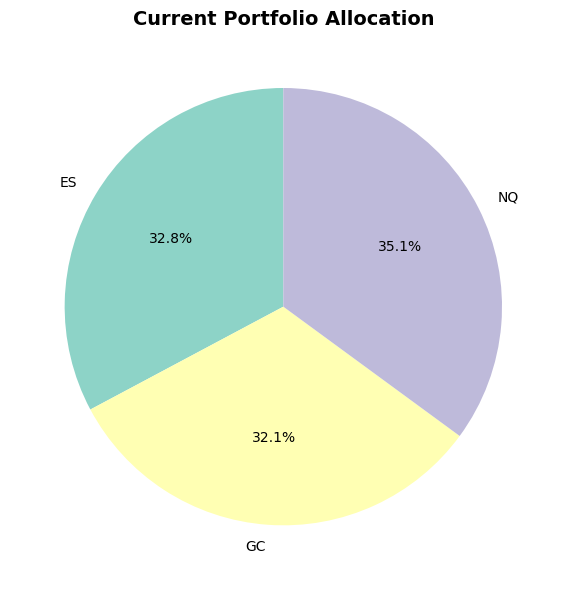


💰 Cash: $284.28
📈 Invested: $132,445.24
💼 Total Value: $132,729.52


In [28]:
# Get current portfolio status
status = engine.get_portfolio_status(prices_current)

# Display current positions
print("📊 Current Portfolio Positions:")
print("=" * 80)

positions_data = []
for pos in status['positions']:  # status['positions'] is a list, not a dict
    shares = pos.get('shares', 0)
    if shares != 0:
        positions_data.append({
            'Ticker': pos['ticker'],
            'Shares': shares,
            'Entry Price': pos.get('entry_price', 0),
            'Current Price': pos.get('current_price', 0),
            'Value': pos.get('position_value', 0),
            'Weight': pos.get('position_value', 0) / status['total_value'] if status['total_value'] > 0 else 0,
            'P&L': pos.get('unrealized_pnl', 0),
            'P&L %': pos.get('unrealized_pct', 0) / 100  # Convert from percentage to decimal
        })

if positions_data:
    positions_df = pd.DataFrame(positions_data)
    
    # Format for display
    display_df = positions_df.copy()
    display_df['Entry Price'] = display_df['Entry Price'].apply(lambda x: f'${x:,.2f}')
    display_df['Current Price'] = display_df['Current Price'].apply(lambda x: f'${x:,.2f}')
    display_df['Value'] = display_df['Value'].apply(lambda x: f'${x:,.2f}')
    display_df['Weight'] = display_df['Weight'].apply(lambda x: f'{x:.1%}')
    display_df['P&L'] = display_df['P&L'].apply(lambda x: f'${x:,.2f}')
    display_df['P&L %'] = display_df['P&L %'].apply(lambda x: f'{x:.2%}')
    
    display(display_df)
    
    # Position pie chart
    if len(positions_df) > 0:
        fig, ax = plt.subplots(figsize=(10, 6))
        colors = plt.cm.Set3(range(len(positions_df)))
        wedges, texts, autotexts = ax.pie(
            positions_df['Value'],
            labels=positions_df['Ticker'],
            autopct='%1.1f%%',
            colors=colors,
            startangle=90
        )
        ax.set_title('Current Portfolio Allocation', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()
else:
    print("No active positions")

print(f"\n💰 Cash: ${status['cash']:,.2f}")
print(f"📈 Invested: ${status['invested']:,.2f}")
print(f"💼 Total Value: ${status['total_value']:,.2f}")


In [29]:
report = engine.generate_daily_report(
    prices_dict=prices_current,
    signals_dict=signals_current,
    live_start_date=LIVE_START
)

print(report)

# Optionally save to file
report_file = project_root / 'reports' / f'daily_report_{datetime.now().strftime("%Y%m%d")}.txt'
report_file.parent.mkdir(exist_ok=True)
report_file.write_text(report)
print(f"\n💾 Report saved to: {report_file}")

PAPER TRADING DAILY REPORT

As of: 2025-11-26

Portfolio Value: $132,729.52
  Cash: $284.28
  Invested: $132,445.24
  Total Return: 32.73%

📍 Open Positions: 3

  ES:
    Shares: 6
    Current: $6841.50
    Value: $43,433.75
    Entry: $5305.75 on 2025-04-16
    Unrealized P&L: $9,749.82 (+28.95%)

  GC:
    Shares: 10
    Current: $4203.60
    Value: $42,564.11
    Entry: $3326.60 on 2025-04-16
    Unrealized P&L: $8,880.18 (+26.36%)

  NQ:
    Shares: 2
    Current: $25351.75
    Value: $46,447.38
    Entry: $18385.25 on 2025-04-16
    Unrealized P&L: $12,763.44 (+37.89%)

📊 Current Signals:
  ES: LONG
  GC: LONG
  NQ: LONG

📈 Live Performance (from 2025-01-01):
  Return: 31.33%
  P&L: $31,664.86
  Trades: 6
  Days: 228

📊 Backtest Reference:
  Total Return: 122.05%
  CAGR: 8.15%
  Sharpe: 0.726


💾 Report saved to: /Users/Sakarias/QuantTrading/reports/daily_report_20251126.txt


## Phase 7: Visualization

Plot equity curves.

           Date     TotalValue           Cash  \
0    2010-01-04  100000.000000  100000.000000   
1    2010-01-05  100000.000000  100000.000000   
2    2010-01-06  100000.000000  100000.000000   
3    2010-01-07  100000.000000  100000.000000   
4    2010-01-08  100000.000000  100000.000000   
...         ...            ...            ...   
2560 2020-03-10  256748.892241     252.645533   
2561 2020-03-11  249170.645793     252.645533   
2562 2020-03-12  231178.295606     252.645533   
2563 2020-03-13  239622.925111     252.645533   
2564 2020-03-16  222051.647380     252.645533   

                                              Positions  
0     {'ES': {'Shares': 0, 'Price': 1128.75, 'Value'...  
1     {'ES': {'Shares': 0, 'Price': 1132.25, 'Value'...  
2     {'ES': {'Shares': 0, 'Price': 1133.0, 'Value':...  
3     {'ES': {'Shares': 0, 'Price': 1137.5, 'Value':...  
4     {'ES': {'Shares': 0, 'Price': 1141.5, 'Value':...  
...                                                 ...  
2560 

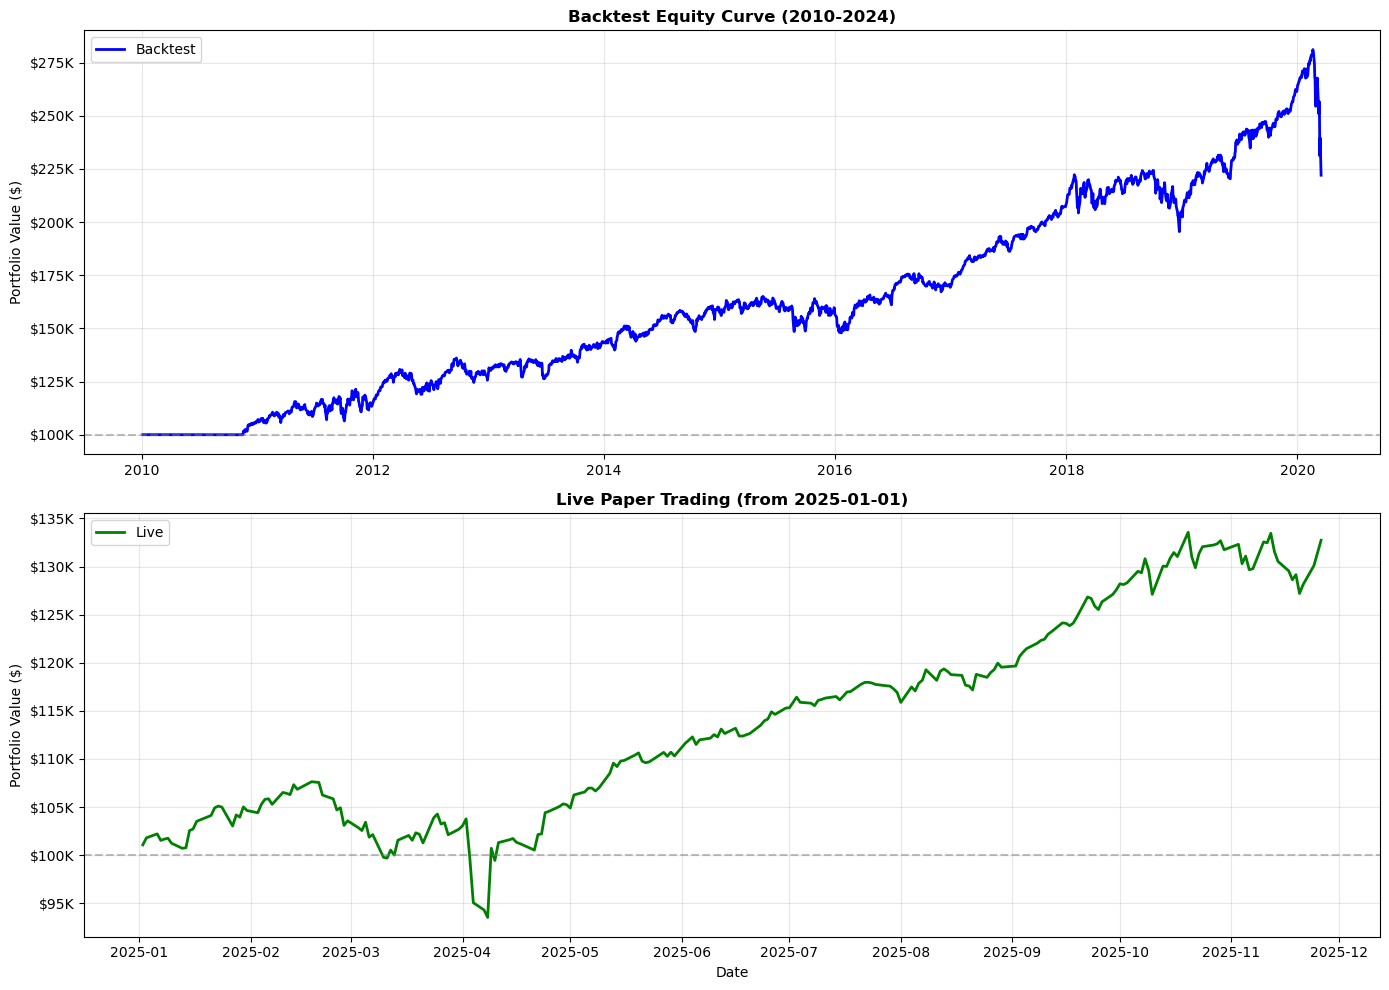

In [30]:
# Get equity curves
equity_live = engine.state.equity_curve
live_start_dt = pd.to_datetime(LIVE_START)
equity_live_only = equity_live[pd.to_datetime(equity_live['Date']) >= live_start_dt].copy()

# Plot
fig, axes = plt.subplots(2, 1, figsize=(14, 10))
print(engine.state.backtest_equity)
# Backtest equity curve
ax1 = axes[0]
if engine.state.backtest_equity is not None:
    ax1.plot(engine.state.backtest_equity["Date"], 
             engine.state.backtest_equity['TotalValue'], 
             linewidth=2, color='blue', label='Backtest')
    ax1.axhline(y=INITIAL_CAPITAL, color='gray', linestyle='--', alpha=0.5)
    ax1.set_title('Backtest Equity Curve (2010-2024)', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Portfolio Value ($)', fontsize=10)
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))

# Live equity curve
ax2 = axes[1]
if len(equity_live_only) > 0:
    dates = pd.to_datetime(equity_live_only['Date'])
    ax2.plot(dates, equity_live_only['TotalValue'], 
             linewidth=2, color='green', label='Live')
    ax2.axhline(y=INITIAL_CAPITAL, color='gray', linestyle='--', alpha=0.5)
    ax2.set_title(f'Live Paper Trading (from {LIVE_START})', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Portfolio Value ($)', fontsize=10)
    ax2.set_xlabel('Date', fontsize=10)
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))

plt.tight_layout()
plt.show()

## Summary

### Advantages of PaperTradingEngine Architecture:

✅ **State Persistence**: Portfolio state survives notebook restarts

✅ **Clean API**: Simple methods replace complex filtering logic

✅ **Production Ready**: Same code works in notebooks and automation scripts

✅ **Maintainable**: Business logic in class, not scattered across cells

✅ **Testable**: Unit tests can validate each component

### Next Steps:

1. **Daily Automation**: Create script that runs Phase 3-6 automatically
2. **Unit Tests**: Add comprehensive test coverage
3. **Alerting**: Add email/SMS notifications for violations
4. **Multiple Strategies**: Run parallel paper trading for different configs
5. **Performance Attribution**: Analyze which trades/assets perform best

## Fix Applied: Fresh Risk Manager

The `PaperTradingEngine` has been updated to use a **fresh risk manager** for live trading, preventing backtest violations (like drawdown stops) from carrying over.

**To apply the fix:**
1. Delete the existing state file: `STATE_FILE.unlink()` (run cell below)
2. Re-run Phase 2 (Initialize) to create fresh state
3. The portfolio will now trade based on live performance only

# Reset paper trading state to apply the fix
print("Resetting paper trading state...")

if STATE_FILE.exists():
    STATE_FILE.unlink()
    print(f"✅ Deleted: {STATE_FILE}")
    print("\n⚠️  Now re-run Phase 2 (Initialize) to create fresh state")
    print("   The new state will use a fresh risk manager without backtest violations")
else:
    print(f"ℹ️  State file doesn't exist: {STATE_FILE}")
    print("   Just run Phase 2 (Initialize) normally")

In [31]:
print("Detailed Trade Analysis:")
print(f"Total trades: {len(engine.state.trades)}")
print(f"\nTrade types:")
print(engine.state.trades['Type'].value_counts())
print(f"\nP&L Statistics (for closed positions):")
if 'PnL' in engine.state.trades.columns:
    closed_trades = engine.state.trades[engine.state.trades['PnL'] != 0]
    print(f"  Closed trades with P&L: {len(closed_trades)}")
    if len(closed_trades) > 0:
        print(f"  Min: ${closed_trades['PnL'].min():,.2f}")
        print(f"  Max: ${closed_trades['PnL'].max():,.2f}")
        print(f"  Mean: ${closed_trades['PnL'].mean():,.2f}")
        print(f"  Median: ${closed_trades['PnL'].median():,.2f}")

Detailed Trade Analysis:
Total trades: 9

Trade types:
Type
Rebalance    6
Entry        3
Name: count, dtype: int64

P&L Statistics (for closed positions):
